In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from lumicks import pylake
import re

from lmfit import models
from scipy.signal import find_peaks, peak_prominences

import glob
%matplotlib inline

Directory:

Parameters:

In [2]:
#finding files
#seems like having issues with named file formats

k='6'
dire= '/mnt/d/OneDrive - Johns Hopkins University/Ha_CCarcamo/Data/C_Trap/2019-08-27_SWR1_ATP/h5/'
filename= glob.glob(dire + ("* {}.*h5").format(k))
print(filename)
file = pylake.File(filename[0])
# print(file)
kymo=file.kymos[k]

['/mnt/d/OneDrive - Johns Hopkins University/Ha_CCarcamo/Data/C_Trap/2019-08-27_SWR1_ATP/h5/20190827-191243 Kymograph 6.h5']


In [3]:
bn=3 #bin n frames
icolor=1 #1 is green, 0 is red

#---gaussian fitting
#-decrease sigma if too much random stuff, dataspread=6 is ok
sigmacutoff=0.6 #accept fits with sigma<this
dataspread=6 #how much data from center you're fitting

#---peak finder
#-change height if data is noisy, dist=5 is ok
pkheight=0.4 #need peaks of at least pkheight*MaxIntensity
dbtwnpks=5 #distance from peak to peak

#---group making
#-generally don't change these (close=0.3,length=5)
howclose=0.3 #um; how close are you calling nearby
minlength=5

#--MSD calculations
msdcutoff=0.25 #what fraction of trace to fit

Load images and times, and bin

In [4]:
green=kymo.green_image # Claudia Comment: green variable should really be called channel color
if icolor!=1:
    green=kymo.red_image 
gtimes=np.array((kymo.timestamps-kymo.timestamps[0,0])/1e9)
gt=np.mean(gtimes,axis=0)

pos=np.arange(len(green))*0.1 #distance in um
rgre=[] #binned green intensities
bnt=[]  #binned times
for i in range(0,len(green[0])-bn+1):
    if i%bn==0:
        vs=np.array(green[:,i])
        ts=gt[i]
        for ib in range(1,bn):
            vs+=np.array(green[:,i+ib]) # Claudia Question: Is this the binning step?
            ts+=gt[i+ib] # Claudia Comment: This is where you move on to the next bin start point
        rgre.append(vs)
        bnt.append(ts/bn)   
rgre=np.array(rgre)

Initialize guesses for peaks:

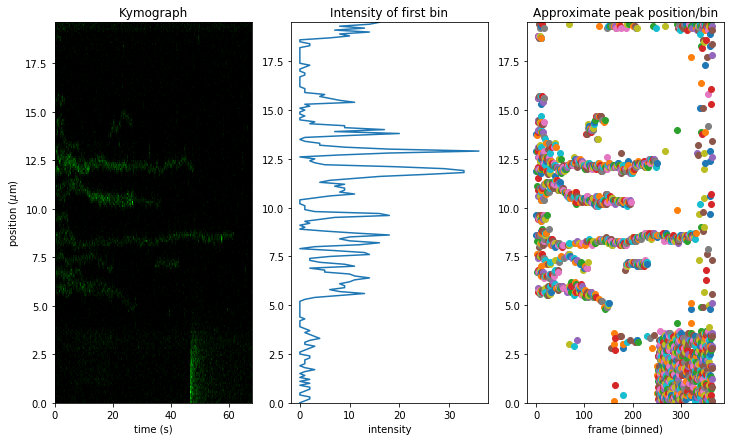

In [5]:
#initial guesses for peaks
plt.figure(figsize=(12,7))

plt.subplot(1,3,3) #find the peaks
pklst=[] #peak position list of each bin
for idx,r in enumerate(rgre):
    peaks,_=find_peaks(r,height=max(r)*pkheight,distance=dbtwnpks)
    pklst.append(peaks)
    plt.scatter([idx]*len(peaks),pos[len(pos)-1]-peaks*0.1)  

plt.xlabel('frame (binned)')
plt.ylim(0,pos[len(pos)-1])
plt.title('Approximate peak position/bin')

plt.subplot(1,3,2)
plt.plot(rgre[0],np.flip(pos))
plt.xlabel('intensity')
plt.ylim(0,pos[len(pos)-1])
plt.title('Intensity of first bin')
#plt.plot(pklst[0],rgre[0][pklst[0]],"x")


plt.subplot(1,3,1)
kymo.plot_green(aspect='auto')
if icolor!=1:
    kymo.plot_red(aspect='auto')    
plt.title('Kymograph');
plt.savefig(dire+'guess-'+k+'.png')

(optional) Check peaks found

[  7  39  51  56  66  74  80  86 101 109 120 127 138]


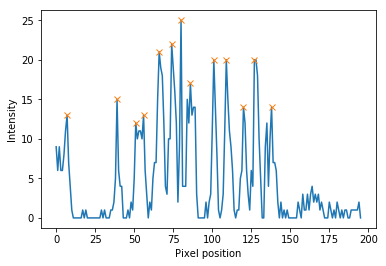

In [6]:
#[optional]
n=3 #check peak finding in specific frames
plt.plot(rgre[n])
plt.plot(pklst[n],rgre[n][pklst[n]],"x")
plt.xlabel('Pixel position')
plt.ylabel('Intensity')

print(pklst[n])

(optional) Check individual peak fit

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 12
    # variables        = 3
    chi-square         = 87.4152713
    reduced chi-square = 9.71280792
    Akaike info crit   = 29.8291602
    Bayesian info crit = 31.2838801
[[Variables]]
    amplitude:  8.87814063 +/- 0.74852798 (8.43%) (init = 36)
    center:     6.59797557 +/- 0.01058000 (0.16%) (init = 6.6)
    sigma:      0.10859375 +/- 0.01055691 (9.72%) (init = 1)
    fwhm:       0.25571873 +/- 0.02485961 (9.72%) == '2.3548200*sigma'
    height:     32.6157435 +/- 2.74914180 (8.43%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.577


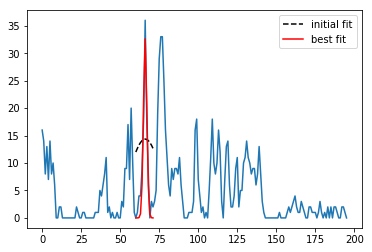

In [8]:
#[optional]
#fit the peak(n) of a specified bin(time)  
bnn=0 #bin
n=1 #peak number

pkpos=pklst[bnn][n] #peak position frame guess
ampguess=rgre[bnn][pkpos] #amplitude guess

#data
x=pos[pkpos-dataspread:pkpos+dataspread]
y=rgre[bnn][pkpos-dataspread:pkpos+dataspread]

gmod=models.GaussianModel()
result=gmod.fit(y,x=x,amplitude=ampguess,center=pos[pkpos],sigma=1)
#print(result.params['amplitude'].value)
#print(result.params['center'].value)
print(result.fit_report())

plt.plot(rgre[bnn])
plt.plot(x*10,result.init_fit,'k--',label='initial fit')
plt.plot(x*10,result.best_fit,'r-',label='best fit')
plt.legend(loc='best');

Fitting everything:

In [9]:
#fit peaks of all bins, output large array of [bin(time) center amplitude]
#this takes a long time and will take forever

my_fits=[]
gmod=models.GaussianModel()

for bn,rg in enumerate(rgre):
    for pkpos in pklst[bn]:
        ampguess=rg[pkpos]
        
        x=pos[pkpos-dataspread:pkpos+dataspread]
        y=rgre[bn][pkpos-dataspread:pkpos+dataspread]
        
        if len(x)==0: #if near image bounds, don't use this peak
            continue
        
        result=gmod.fit(y,x=x,amplitude=ampguess,center=pos[pkpos],sigma=1)
        if result.params['sigma'].value<sigmacutoff: #cutoff the weird errors
            my_fits.append([bn,result.params['center'].value,result.params['amplitude'].value])               

(optional) Check fits

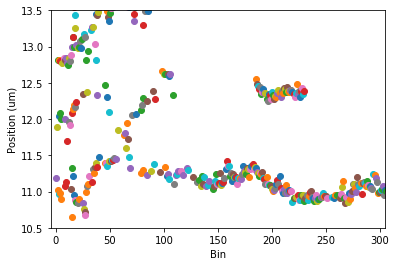

In [10]:
#[optional]
#checking the fits
for ft in my_fits:
    plt.scatter(ft[0],ft[1])
    
plt.ylabel('Position (um)')
plt.xlabel('Bin');

#change these to specific areas you want to look at
#comment if want to see all
plt.ylim(10.5,13.5)
plt.xlim(-5,305);

Make the groups: ***

In [11]:
#connecting the dots (making groups)
#still in progress
myfits=my_fits.copy() #so don't have to keep re running fitting part
groups=[]

while len(myfits):
    group=[]
    cc=myfits[0]
    group.append(cc)
    myfits.remove(cc)
    for ft in myfits[:]:
        if ft[0]==cc[0]+1 and np.abs(cc[1]-ft[1])<howclose:
            group.append(ft)
            cc=ft
            myfits.remove(ft)
    if len(group)>=minlength: #trajectories have to be at least n frames
        groups.append(group)

(optional) plot groups side by side

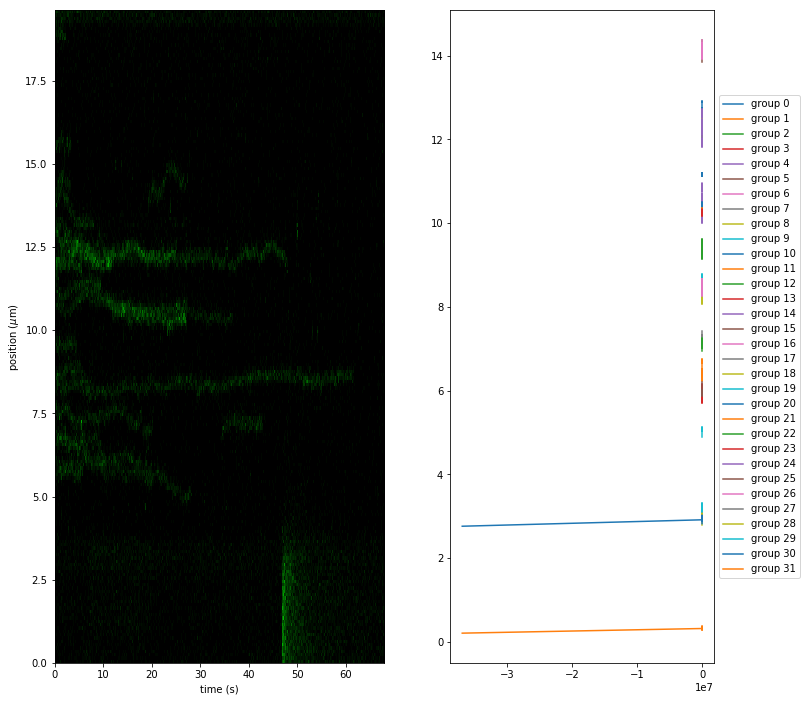

In [19]:
#[optional]
#plot the groups by color (side by side)
fig = plt.figure(figsize=(13,12))
plt.subplot(121)
kymo.plot_green(aspect='auto')
if icolor!=1:
    kymo.plot_red(aspect='auto')
plt.title('');

ax = plt.subplot(122)

for idx,group in enumerate(groups):
    x=[]
    y=[]
    for i in group:
        x.append(bnt[i[0]])
        y.append(i[1])
    plt.plot(x,pos[len(pos)-1]-y,label='group %i'%idx)

#plt.ylabel('position (um)')
#plt.xlabel('frame (bin)');

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.savefig(dire+'trace_besides-'+k+'.png', bbox_inches="tight")


(optional) plot groups overlaid on image

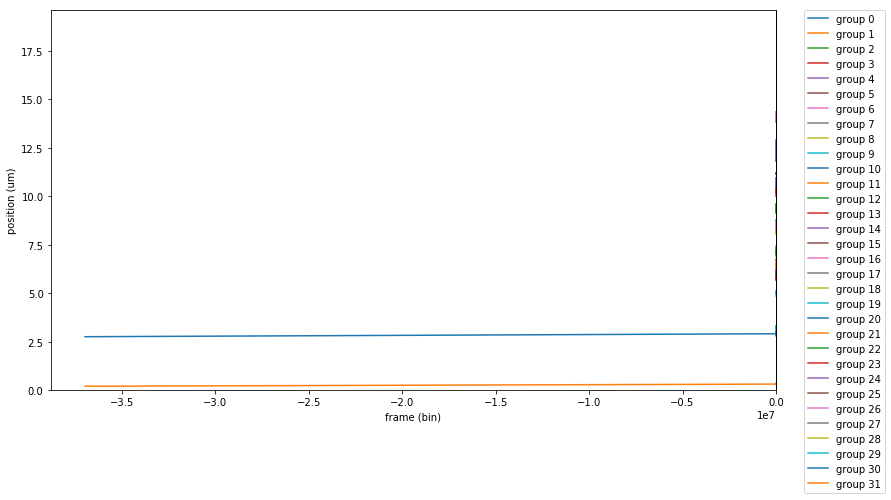

In [18]:
#[optional]
#plot the groups by color (overlaid)
fig = plt.figure(figsize=(13,7))
#plt.subplot(121)
kymo.plot_green(aspect='auto')
if icolor!=1:
    kymo.plot_red(aspect='auto')
plt.title('');

for idx,group in enumerate(groups):
    x=[]
    y=[]
    for i in group:
        x.append(bnt[i[0]])
        y.append(i[1])
    plt.plot(x,pos[len(pos)-1]-y,label='group %i'%idx)


# Put a legend to the right of the current axis
#plt.subplots_adjust(right=0.7)
plt.legend(bbox_to_anchor=(1.15,1), borderaxespad=0);
plt.ylabel('position (um)');
plt.xlabel('frame (bin)');
plt.savefig(dire+'trace_overlay-'+k+'.png', bbox_inches="tight")




(optional) combine groups

In [ ]:
#[optional]
#decide if want to combine groups
#in progress

(optional) save data as text

In [14]:
#[optional]
#save your data as txt
#need to add amplitudes
svfile = []
for gn,group in enumerate(groups):
    for i in group:
        t=bnt[i[0]]
        p=pos[len(pos)-1]-i[1]
        rw = [p,t,gn]
        svfile.append(rw)
        
finame=dire+"kymo-traces-"+k+'.txt'
np.savetxt(finame,svfile)

Zero the trajectories:

32 groups


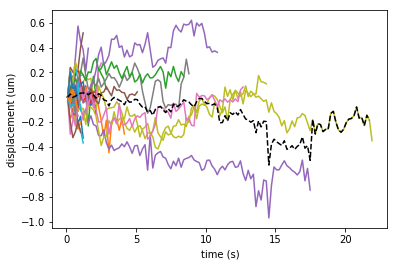

In [15]:
#plot all trajectories zero'd at t=0
svfile = []
for gn,group in enumerate(groups):
    for i in group:
        t=bnt[i[0]]
        p=pos[len(pos)-1]-i[1]
        rw = [p,t,gn] #row is made of [position, time, group index]
        svfile.append(rw)
        
svfile=np.array(svfile)
ngroups=np.max([i for i in svfile[:,2]])
print('%d groups' %(ngroups+1))

#plot each trajectory
ztraj=[]
for r in range(int(ngroups)+1):
    gr=svfile[svfile[:,2]==r]
    y=gr[:,0]-gr[0,0]
    x=bnt[0:len(y)]
    for i,a in enumerate(y):
        rw=[x[i],a,r]
        ztraj.append(rw)
    plt.plot(x,y)


ztraj=np.array(ztraj)
maxtime=np.max([i for i in ztraj[:,0]])
#mean each timepoint displacement
mdisp=[]
for t in bnt[0:bnt.index(maxtime)]:
    mdt=ztraj[ztraj[:,0]==t]
    if mdt.size==0:
        print('nothing')
        mdt=np.array([[np.nan,np.nan,np.nan]])
    md=np.nanmean(mdt[:,1])
    #print('')
    mdisp.append([t,md])

mdisp=np.array(mdisp)
plt.plot(mdisp[:,0],mdisp[:,1],'k--')
plt.xlabel('time (s)')
plt.ylabel('displacement (um)');
plt.savefig(dire+'all_traces-'+k+'.png')

Get MSD of each group:

19 good MSDs


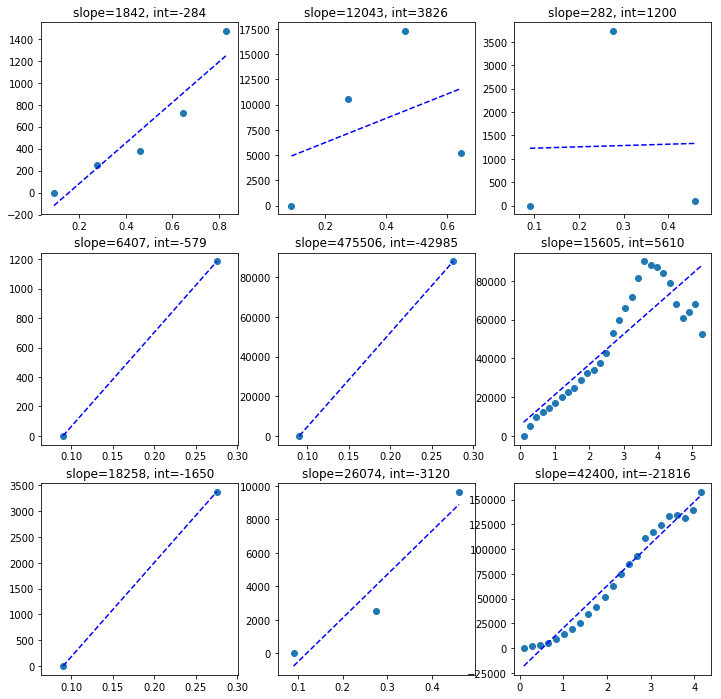

In [16]:
#get MSD for groups???
def msd_1d(x): #http://mglerner.com/Optimizing%20MSD%20calculations.html
    result = np.zeros_like(x)
    for i in range(1,len(x)):
        result[i] = np.average((x[i:] - x[:-i])**2)
    return result

lmod=models.LinearModel()
fig=plt.figure(figsize=(12,12))
msds=[] #each MSD
rr=0
for r in range(int(ngroups+1)):
    gr=svfile[svfile[:,2]==r]
    gr=gr[0:int(msdcutoff*len(gr))] #cutoff in time here
    if len(gr)<=1:
        continue
    m=msd_1d(gr[:,0]*1000)
    t=np.array(bnt[0:len(m)])
    result=lmod.fit(m,x=t,nan_policy='omit')
    sl=result.params['slope'].value
    intc=result.params['intercept'].value

    if rr+1<=9:
        fig.add_subplot(3,3,rr+1)
        plt.title('slope=%d, int=%d' %(sl,intc))
        plt.scatter(t,m)
        plt.plot(t,t*sl+intc,'b--')
        rr+=1
    #print(result.fit_report())
    msds.append(m)
    
print(str(len(msds))+' good MSDs')
plt.savefig(dire+'sample_fits-'+k+'.png')


Get MSD of average of all groups:

ValueError: x and y must be the same size

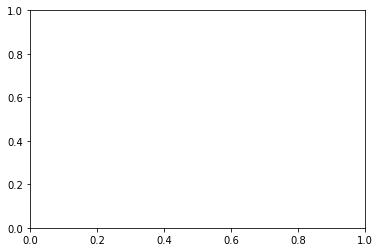

In [17]:
#for just the total/average MSD  
timestep=bnt[1]-bnt[0]
lmod=models.LinearModel()

mm=mdisp[0:int(msdcutoff*len(mdisp))]
m=msd_1d(mm[:,1]*1000)
t=np.arange(0,timestep*len(m),timestep)
plt.scatter(t,m)

result=lmod.fit(m,x=t,nan_policy='omit')
sl=result.params['slope'].value
intc=result.params['intercept'].value
plt.plot(t,t*sl+intc,'b--')
plt.xlabel('time (s)')
plt.ylabel('MSD ($nm^2$/s)')
plt.title('slope=%d, int=%d' %(sl,intc))

print(result.fit_report())
plt.savefig(dire+'avg_MSD-'+k+'.png')


## Random code testing area

In [ ]:
#how to go through a loop that removes things from list
a=[1,2,3,4,5,6,7,8,9]
while len(a):
    print(a)
    for i in a[:]:
        if random.random() > 0.5:
            print("removing: %d" % i)
            a.remove(i)
        else:
            print("keeping: %d"  % i)

In [ ]:
x=np.array([[1,2,3],[4,5,6],[7,8,9]])
print(x[0:int(0.7*len(x))])

In [ ]:
x=[1,2,3,4,5]
print(x[0:int(0.25*len(x))])